# Stealing Machine Learning Models

This notebook is a demonstration of stealing CNN Deep Neural Network (DNN) models throught API calls. Put simply, given a black box access to a DNN, can we retrain a 'knock-off'`*` DNN which mimics the orignal DNN model. The general theory has been laid out in the paper [Stealing Machine Learning Models vi Prediction API](https://www.usenix.org/conference/usenixsecurity16/technical-sessions/presentation/tramer). Even though the paper provides techniques to steal various ML models, it doesn't go beyond MLP classifiers. In this notebook, we use the same techniques used with MLP classifiers and extend them to run on CNNs.

## What's the big deal?
Whereas stealing a Logistic Regresssion models would be finding the unknowns and solving for them. Since the LR models are essentially linear systems, given $n+1$ equations, $n$ variables can be solved for; thus, essentially 'reverse-engineering' the entire LR model. The internals of an MLP, however, can't be expressed as a linear system; in other words, the MLPs are not strongly convex and hence we may not always be able to steal the MLP models entirely. The sitatution is made even worse for CNNs, which are sparsefly connected and often comparatively larger networks; this notebook is all about CNNs.

## Constraints:
* The attacker has full knowledge of CNN architecture.
* The attacker has access to the model to be stolen such that the attacker can send an instance to the victim model and get a prediction back.
* The attacker doesn't have access to the actual training set.

> NOTE: Below we have three sections- each per different dataset (and potentially a differnt CNN model architecture or hyperparameters). They are completely independent of each other, and may be run independently.


## Results:
| Dataset  | Model Acc | Stolen Model Acc.  | Stolen Model Relative Acc. |  
|:--|---|---|---|
| MNIST  | 99% | 79% | 79.7%  | 
|  FashionMNIST | 87%  | 38% | 43%  | 
|  CIFAR10 | 61% | 31%  | 50.8%  |  



`*` For another publication on stealing DNNs with a similar nomenclature, see [this](https://arxiv.org/abs/1812.02766).

# MNIST

## MNIST Training the model to be stolen

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms


In [33]:
FORCE_CPU = False
if torch.cuda.is_available() and not FORCE_CPU:  
  dev = "cuda:0" 
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:  
  dev = "cpu"  

device = torch.device(dev) 
print(device)

cuda:0


In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

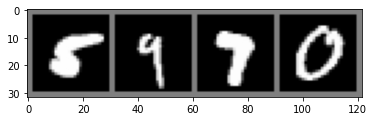

GroundTruth:  ['5', '9', '7', '0']


In [27]:
import matplotlib.pyplot as plt
import numpy as np

label_tags = [str(i) for i in range(10)]


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', [label_tags[j] for j in labels])

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(4): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.154
[1,  4000] loss: 0.188
[1,  6000] loss: 0.130
[1,  8000] loss: 0.110
[1, 10000] loss: 0.096
[1, 12000] loss: 0.080
[1, 14000] loss: 0.085
[2,  2000] loss: 0.066
[2,  4000] loss: 0.067
[2,  6000] loss: 0.058
[2,  8000] loss: 0.054
[2, 10000] loss: 0.060
[2, 12000] loss: 0.050
[2, 14000] loss: 0.055
[3,  2000] loss: 0.037
[3,  4000] loss: 0.039
[3,  6000] loss: 0.038
[3,  8000] loss: 0.043
[3, 10000] loss: 0.042
[3, 12000] loss: 0.046
[3, 14000] loss: 0.040
[4,  2000] loss: 0.031
[4,  4000] loss: 0.028
[4,  6000] loss: 0.035
[4,  8000] loss: 0.030
[4, 10000] loss: 0.026
[4, 12000] loss: 0.035
[4, 14000] loss: 0.033
Finished Training


In [76]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


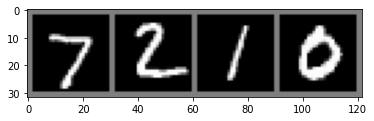

Predictions:  ['7', '2', '1', '0']


In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = torch.max(net(images.to(device)).data, 1)[1]
imshow(torchvision.utils.make_grid(images))
print('Predictions: ', [label_tags[j] for j in list(outputs)])

In [46]:
net.requires_grad_ = False

# MNIST Stealing Models

In [75]:
NUM_RANDOM_POINTS = 80_000
BATCH_SIZE = 4

In [77]:
X, Y = [], []
for _ in range(int(NUM_RANDOM_POINTS/BATCH_SIZE)):
  X.append(torch.rand((BATCH_SIZE,1,28,28))*2 -1)
  Y.append(net(X[-1]).data)

In [78]:
stolen_net = Net()
stolen_net = stolen_net.cuda()

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.SGD(stolen_net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(25): 

    running_loss = 0.0
    for i, data in enumerate(zip(X,Y), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = stolen_net(inputs)
        #loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss = criterion(outputs, labels.data)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  4000] loss: 0.750
[1,  8000] loss: 0.714
[1, 12000] loss: 0.625
[1, 16000] loss: 0.553
[1, 20000] loss: 0.447
[2,  4000] loss: 0.380
[2,  8000] loss: 0.331
[2, 12000] loss: 0.295
[2, 16000] loss: 0.264
[2, 20000] loss: 0.243
[3,  4000] loss: 0.225
[3,  8000] loss: 0.209
[3, 12000] loss: 0.199
[3, 16000] loss: 0.189
[3, 20000] loss: 0.182
[4,  4000] loss: 0.171
[4,  8000] loss: 0.160
[4, 12000] loss: 0.152
[4, 16000] loss: 0.143
[4, 20000] loss: 0.137
[5,  4000] loss: 0.124
[5,  8000] loss: 0.114
[5, 12000] loss: 0.106
[5, 16000] loss: 0.100
[5, 20000] loss: 0.097
[6,  4000] loss: 0.092
[6,  8000] loss: 0.088
[6, 12000] loss: 0.085
[6, 16000] loss: 0.083
[6, 20000] loss: 0.082
[7,  4000] loss: 0.079
[7,  8000] loss: 0.076
[7, 12000] loss: 0.074
[7, 16000] loss: 0.072
[7, 20000] loss: 0.070
[8,  4000] loss: 0.067
[8,  8000] loss: 0.065
[8, 12000] loss: 0.063
[8, 16000] loss: 0.061
[8, 20000] loss: 0.060
[9,  4000] loss: 0.058
[9,  8000] loss: 0.056
[9, 12000] loss: 0.055
[9, 16000] 

In [80]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = stolen_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the stolen network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the stolen network on the 10000 test images: 79 %


In [ ]:
"""
WARN: Run this cell only if you're sure that you don't 
need any of the results in the previous sections.
"""
import gc
import time
del net
del stolen_net
del X
del Y
gc.collect();time.sleep(1);gc.collect()

## Conclusion and Summary

We are able to steal the model to a great extent using random inputs only! Our final stolen model has an accuracy of 79% and the model had only API access to an original CNN model trained on MNIST dataset.

# Fashion MNIST

## Fashion-MNIST Training the model

In [83]:
import torch
import torchvision
import torchvision.transforms as transforms

In [84]:
FORCE_CPU = False
if torch.cuda.is_available() and not FORCE_CPU:  
  dev = "cuda:0" 
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:  
  dev = "cpu"  

device = torch.device(dev) 
print(device)

cuda:0


In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


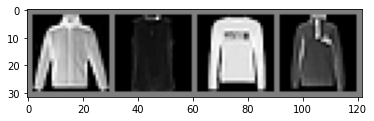

GroundTruth:  ['Coat', 'Shirt', 'Pullover', 'Pullover']


In [86]:
import matplotlib.pyplot as plt
import numpy as np

label_tags = ["T-shirt/top", "Trouser", "Pullover", "Dress", 
              "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', [label_tags[j] for j in labels])


In [87]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(4): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.454
[1,  4000] loss: 0.688
[1,  6000] loss: 0.577
[1,  8000] loss: 0.546
[1, 10000] loss: 0.492
[1, 12000] loss: 0.472
[1, 14000] loss: 0.449
[2,  2000] loss: 0.423
[2,  4000] loss: 0.409
[2,  6000] loss: 0.409
[2,  8000] loss: 0.383
[2, 10000] loss: 0.386
[2, 12000] loss: 0.361
[2, 14000] loss: 0.377
[3,  2000] loss: 0.353
[3,  4000] loss: 0.336
[3,  6000] loss: 0.344
[3,  8000] loss: 0.354
[3, 10000] loss: 0.347
[3, 12000] loss: 0.341
[3, 14000] loss: 0.330
[4,  2000] loss: 0.317
[4,  4000] loss: 0.310
[4,  6000] loss: 0.316
[4,  8000] loss: 0.329
[4, 10000] loss: 0.297
[4, 12000] loss: 0.314
[4, 14000] loss: 0.316
Finished Training


In [88]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


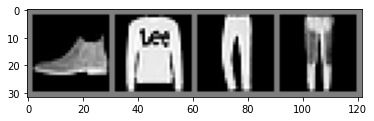

Predictions:  ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']


In [89]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = torch.max(net(images.to(device)).data, 1)[1]
imshow(torchvision.utils.make_grid(images))
print('Predictions: ', [label_tags[j] for j in list(outputs)])

In [90]:
net.requires_grad_ = False

# Fashion-MNIST Stealing Models

In [103]:
NUM_RANDOM_POINTS = 60_000
BATCH_SIZE = 8

In [104]:
X, Y = [], []
for _ in range(int(NUM_RANDOM_POINTS/BATCH_SIZE)):
  X.append(torch.rand((BATCH_SIZE,1,28,28))*2 -1)
  Y.append(net(X[-1]).data)

In [105]:
stolen_net = Net()
stolen_net = stolen_net.cuda()

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.SGD(stolen_net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(20): 

    running_loss = 0.0
    for i, data in enumerate(zip(X,Y), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = stolen_net(inputs)
        #loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss = criterion(outputs, labels.data)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  4000] loss: 0.723
[2,  4000] loss: 0.164
[3,  4000] loss: 0.085
[4,  4000] loss: 0.066
[5,  4000] loss: 0.057
[6,  4000] loss: 0.052
[7,  4000] loss: 0.049
[8,  4000] loss: 0.047
[9,  4000] loss: 0.045
[10,  4000] loss: 0.043
[11,  4000] loss: 0.041
[12,  4000] loss: 0.039
[13,  4000] loss: 0.038
[14,  4000] loss: 0.037
[15,  4000] loss: 0.036
[16,  4000] loss: 0.035
[17,  4000] loss: 0.033
[18,  4000] loss: 0.032
[19,  4000] loss: 0.031
[20,  4000] loss: 0.030
Finished Training


In [106]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = stolen_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the stolen network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the stolen network on the 10000 test images: 38 %


## Conclusion and Summary

We are able to steal the model to a great extent using random inputs only! Our final stolen model has an accuracy of 38% and the model had only API access to an original CNN model trained on MNIST dataset.

# CIFAR-10 

## CIFAR-10 Training the model to be stolen

In [107]:
import torch
import torchvision
import torchvision.transforms as transforms

In [108]:
FORCE_CPU = False
if torch.cuda.is_available() and not FORCE_CPU:  
  dev = "cuda:0" 
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:  
  dev = "cpu"  

device = torch.device(dev) 
print(device)

cuda:0


In [122]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


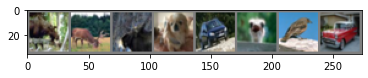

GroundTruth:  ['deer', 'deer', 'deer', 'dog', 'automobile', 'bird', 'bird', 'automobile']


In [119]:
import matplotlib.pyplot as plt
import numpy as np

label_tags = ["airplane","automobile","bird", 
              "cat", "deer", "dog","frog", 
              "horse", "ship", "truck"]


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', [label_tags[j] for j in labels])

In [123]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.232
[1,  4000] loss: 1.874
[1,  6000] loss: 1.695
[1,  8000] loss: 1.583
[1, 10000] loss: 1.530
[1, 12000] loss: 1.487
[2,  2000] loss: 1.417
[2,  4000] loss: 1.390
[2,  6000] loss: 1.355
[2,  8000] loss: 1.342
[2, 10000] loss: 1.331
[2, 12000] loss: 1.294
[3,  2000] loss: 1.218
[3,  4000] loss: 1.224
[3,  6000] loss: 1.226
[3,  8000] loss: 1.205
[3, 10000] loss: 1.172
[3, 12000] loss: 1.175
[4,  2000] loss: 1.094
[4,  4000] loss: 1.111
[4,  6000] loss: 1.097
[4,  8000] loss: 1.134
[4, 10000] loss: 1.095
[4, 12000] loss: 1.080
[5,  2000] loss: 1.013
[5,  4000] loss: 1.037
[5,  6000] loss: 1.037
[5,  8000] loss: 1.032
[5, 10000] loss: 1.027
[5, 12000] loss: 1.034
Finished Training


In [124]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


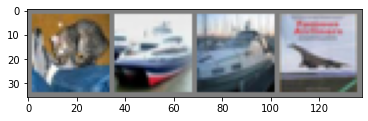

Predictions:  ['cat', 'automobile', 'truck', 'airplane']


In [125]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = torch.max(net(images.to(device)).data, 1)[1]
imshow(torchvision.utils.make_grid(images))
print('Predictions: ', [label_tags[j] for j in list(outputs)])

In [126]:
net.requires_grad_ = False

# CIFAR-10 Stealing Models

In [127]:
NUM_RANDOM_POINTS = 60_000
BATCH_SIZE = 8

In [130]:
X, Y = [], []
for _ in range(int(NUM_RANDOM_POINTS/BATCH_SIZE)):
  X.append(torch.rand((BATCH_SIZE,3,32,32))*2 -1)
  Y.append(net(X[-1]).data)

In [131]:
stolen_net = Net()
stolen_net = stolen_net.cuda()

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.SGD(stolen_net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(20): 

    running_loss = 0.0
    for i, data in enumerate(zip(X,Y), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = stolen_net(inputs)
        #loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss = criterion(outputs, labels.data)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  4000] loss: 1.123
[2,  4000] loss: 0.849
[3,  4000] loss: 0.653
[4,  4000] loss: 0.535
[5,  4000] loss: 0.433
[6,  4000] loss: 0.394
[7,  4000] loss: 0.377
[8,  4000] loss: 0.364
[9,  4000] loss: 0.355
[10,  4000] loss: 0.346
[11,  4000] loss: 0.339
[12,  4000] loss: 0.333
[13,  4000] loss: 0.328
[14,  4000] loss: 0.324
[15,  4000] loss: 0.319
[16,  4000] loss: 0.317
[17,  4000] loss: 0.312
[18,  4000] loss: 0.308
[19,  4000] loss: 0.304
[20,  4000] loss: 0.301
Finished Training


In [132]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = stolen_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the stolen network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the stolen network on the 10000 test images: 31 %


## CIFAR-10 Conclusion and Summary

We are able to steal the model to a great extent using random inputs only! Our final stolen model has an accuracy of 31% and the model had only API access to an original CNN model trained on MNIST dataset.

# Summary of All Results




| Dataset  | Model Acc | Stolen Model Acc.  | Stolen Model Relative Acc. |  
|:--|---|---|---|
| MNIST  | 99% | 79% | 79.7%  | 
|  FashionMNIST | 87%  | 38% | 43%  | 
|  CIFAR10 | 61% | 31%  | 50.8%  |  

